In [359]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import model_selection

In [423]:
class nnDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]
    def __len__(self):
        return self.length
class Net(nn.Module):
    def __init__(self, nInputFeatures):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(nInputFeatures,32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32,1),
            
        )
    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

In [424]:
data = pd.read_csv("Relevantfeatures,1Target.csv")
for CR in data['CR'].unique():
    if(data['CR'][data['CR']==CR].count() < 2):
        print(CR, ": Index Removed, less than two of this CR present")
        data = data[data['CR']!=CR]
    if(CR == 0):
        data = data[data['CR']!=CR]
x = data.drop(columns="CR")
y = data['CR']
xTrain, xTest, yTrain, yTest = model_selection.train_test_split(x, y,test_size=0.5,stratify=y)

26.0 : Index Removed, less than two of this CR present


In [425]:
for i,column in enumerate(xTrain):
    colMin = xTrain[column].max()
    colMax = xTrain[column].min()
    if(colMin == colMax):
        xTrain[column] = xTrain[column]  * 0
        xTest[column] = xTest[column] * 0
    else:
        xTrain[column] = (xTrain[column] - colMin) / (colMax - colMin)
        xTest[column] = (xTest[column] - colMin) / (colMax - colMin)
nnTrainingSet = nnDataset(xTrain.values, yTrain.values)
nnTestingSet = nnDataset(xTest.values, yTest.values)
nnTrainLoader = DataLoader(nnTrainingSet, batch_size=16, shuffle=True)
nnTestLoader = DataLoader(nnTestingSet, batch_size=16, shuffle=False)

In [429]:
model = Net(nInputFeatures=xTrain.shape[1])
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay = 0.002)
fullMSEHistory = []

bestMSE = 10000000
bestWeights = None

Θ = 10000
timeSinceLastUpdate = 0
for θ in range(Θ):
    for batchIDX, (xBatch, yBatch) in enumerate(nnTrainLoader):
        output = model(xBatch)
        loss = mse_loss(output, yBatch.reshape(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(θ%500==0):
        print("On epoch", str(θ))
    timeSinceLastUpdate += 1
    if float(loss)<bestMSE:
        timeSinceLastUpdate = 0
        bestMSE = float(loss)
        bestWeights = copy.deepcopy(model.state_dict())
        print("Better MSE Loss {} achieved on epoch {}".format(loss,θ))
    fullMSEHistory.append(float(loss))
    
    if(timeSinceLastUpdate>=150 and bestMSE<0.01):
        print("No significant updates in 150 epochs and under loss threshold, breaking training")
        break

On epoch 0
Better MSE Loss 112.59752655029297 achieved on epoch 0
Better MSE Loss 1.728986382484436 achieved on epoch 1
Better MSE Loss 1.3151264190673828 achieved on epoch 2
Better MSE Loss 0.7687333226203918 achieved on epoch 17
Better MSE Loss 0.30611374974250793 achieved on epoch 21
Better MSE Loss 0.2522464096546173 achieved on epoch 26
Better MSE Loss 0.18222138285636902 achieved on epoch 52
On epoch 100
Better MSE Loss 0.14396485686302185 achieved on epoch 119
Better MSE Loss 0.10524529963731766 achieved on epoch 123
Better MSE Loss 0.1020134910941124 achieved on epoch 171
Better MSE Loss 0.049106378108263016 achieved on epoch 181
On epoch 200
On epoch 300
On epoch 400
On epoch 500
On epoch 600
Better MSE Loss 0.039248980581760406 achieved on epoch 693
On epoch 700
On epoch 800
On epoch 900
On epoch 1000
On epoch 1100
On epoch 1200
On epoch 1300
On epoch 1400
On epoch 1500
On epoch 1600
On epoch 1700
On epoch 1800
On epoch 1900
On epoch 2000
On epoch 2100
On epoch 2200
On epoch 

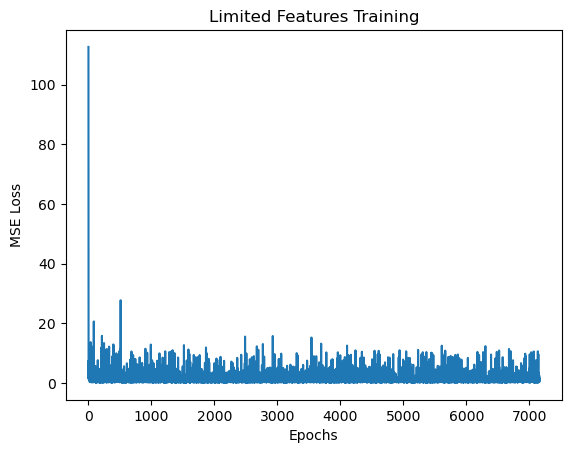

In [430]:
epochs = []
for i in range(θ+1):
    epochs.append(i)
plt.plot(epochs,fullMSEHistory)
plt.xlabel("Epochs")  
plt.ylabel("MSE Loss")  
plt.title("Limited Features Training") 
plt.show()

In [431]:
model.load_state_dict(bestWeights)
total = 0
withinReason = 0
lessWithinReason = 0
outerBoundOfReason = 0
for batchIDX, (xTestBatch, yTestBatch) in enumerate(nnTestLoader):
    output = model(xTestBatch)
    for i, element in enumerate(output):
        element = element.detach().numpy()
        if(np.abs(yTestBatch[i]-element)<1):
            withinReason += 1
        if(np.abs(yTestBatch[i]-element)<2):
            lessWithinReason += 1
        if(np.abs(yTestBatch[i]-element)<3):
            outerBoundOfReason += 1
        total += 1
    loss = float(mse_loss(output, yTestBatch.reshape(-1, 1)))
mse = loss
rootMSE = np.sqrt(mse)
print("Mean Squared Error is: ", mse)
print("RMSE is: ", rootMSE)
print("Predicted CR values within +/- 1.00 of actual CR: ", str(withinReason/total))
print("Predicted CR values within +/- 2.00 of actual CR: ", str(lessWithinReason/total))
print("Predicted CR values within +/- 3.00 of actual CR: ", str(outerBoundOfReason/total))

Mean Squared Error is:  0.3311021327972412
RMSE is:  0.5754147485051467
Predicted CR values within +/- 1.00 of actual CR:  0.6931818181818182
Predicted CR values within +/- 2.00 of actual CR:  0.8798701298701299
Predicted CR values within +/- 3.00 of actual CR:  0.9496753246753247


THIS IS THE START OF THE BIGGER DATAFRAME SECTION

In [208]:
data = pd.read_csv("MostFeatures,1Target.csv")
for CR in data['CR'].unique():
    if(data['CR'][data['CR']==CR].count() < 2):
        print(CR, "Removed, less than two of this CR present")
        data = data[data['CR']!=CR]
    if(CR == 0):
        data = data[data['CR']!=CR]
x = data.drop(columns="CR")
y = data['CR']
xTrain, xTest, yTrain, yTest = model_selection.train_test_split(x, y,test_size=0.5,stratify=y)

26.0 Removed, less than two of this CR present


In [209]:
for i,column in enumerate(xTrain):
    colMin = xTrain[column].max()
    colMax = xTrain[column].min()
    if(colMin == colMax):
        xTrain[column] = xTrain[column]  * 0
        xTest[column] = xTest[column] * 0
    else:
        xTrain[column] = (xTrain[column] - colMin) / (colMax - colMin)
        xTest[column] = (xTest[column] - colMin) / (colMax - colMin)
nnTrainingSet = nnDataset(xTrain.values, yTrain.values)
nnTestingSet = nnDataset(xTest.values, yTest.values)
nnTrainLoader = DataLoader(nnTrainingSet, batch_size=16, shuffle=True)
nnTestLoader = DataLoader(nnTestingSet, batch_size=16, shuffle=False)

In [210]:
class Net(nn.Module):
    def __init__(self, nInputFeatures):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(nInputFeatures,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,16),
            nn.ReLU(),
            nn.Linear(16,1),
            
        )
    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

In [211]:
model = Net(nInputFeatures=xTrain.shape[1])
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005,weight_decay = 0.0001)
fullMSEHistory = []

bestMSE = 10000000
bestWeights = None

Θ = 500
timeSinceLastUpdate = 0
for θ in range(Θ):
    for batchIDX, (xBatch, yBatch) in enumerate(nnTrainLoader):
        output = model(xBatch)
        loss = mse_loss(output, yBatch.reshape(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(θ%100==0):
        print("On epoch", str(θ))
    timeSinceLastUpdate += 1
    fullMSEHistory.append(float(loss))
    if float(loss)<bestMSE:
        timeSinceLastUpdate = 0
        bestMSE = float(loss)
        bestWeights = copy.deepcopy(model.state_dict())
        print("Better MSE Loss {} achieved on epoch {}".format(loss,θ))
    if(timeSinceLastUpdate>=150 and bestMSE<0.01):
        print("No significant updates in 150 epochs and under loss threshold, breaking training")
        break

On epoch 0
Better MSE Loss 17.874603271484375 achieved on epoch 0
Better MSE Loss 8.402405738830566 achieved on epoch 1
Better MSE Loss 3.535475254058838 achieved on epoch 7
Better MSE Loss 1.0861536264419556 achieved on epoch 9
Better MSE Loss 0.7702497839927673 achieved on epoch 16
Better MSE Loss 0.39031678438186646 achieved on epoch 20
Better MSE Loss 0.06483390182256699 achieved on epoch 40
On epoch 100
Better MSE Loss 0.051868464797735214 achieved on epoch 124
On epoch 200
Better MSE Loss 0.05121418461203575 achieved on epoch 236
Better MSE Loss 0.042656123638153076 achieved on epoch 242
On epoch 300
Better MSE Loss 0.03747975081205368 achieved on epoch 362
Better MSE Loss 0.022091656923294067 achieved on epoch 387
On epoch 400


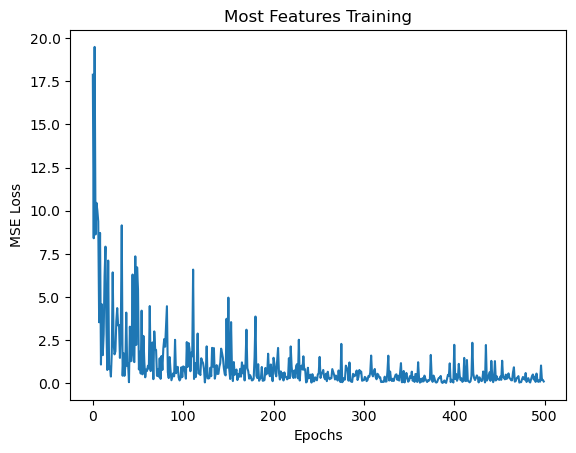

In [212]:
epochs = []
for i in range(θ+1):
    epochs.append(i)
plt.plot(epochs,fullMSEHistory)
plt.xlabel("Epochs")  
plt.ylabel("MSE Loss")  
plt.title("Most Features Training") 
plt.show()

In [213]:
model.load_state_dict(bestWeights)
total = 0
withinReason = 0
lessWithinReason = 0
outerBoundOfReason = 0
for batchIDX, (xTestBatch, yTestBatch) in enumerate(nnTestLoader):
    output = model(xTestBatch)
    for i, element in enumerate(output):
        element = element.detach().numpy()
        if(np.abs(yTestBatch[i]-element)<1):
            withinReason += 1
        if(np.abs(yTestBatch[i]-element)<2):
            lessWithinReason += 1
        if(np.abs(yTestBatch[i]-element)<3):
            outerBoundOfReason += 1
        total += 1
    loss = float(mse_loss(output, yTestBatch.reshape(-1, 1)))
mse = loss
rootMSE = np.sqrt(mse)
print("Mean Squared Error is: ", mse)
print("RMSE is: ", rootMSE)
print("Predicted CR values within +/- 1.00 of actual CR: ", str(withinReason/total))
print("Predicted CR values within +/- 2.00 of actual CR: ", str(lessWithinReason/total))
print("Predicted CR values within +/- 3.00 of actual CR: ", str(outerBoundOfReason/total))

Mean Squared Error is:  0.8510463237762451
RMSE is:  0.9225217199482325
Predicted CR values within +/- 1.00 of actual CR:  0.685064935064935
Predicted CR values within +/- 2.00 of actual CR:  0.875
Predicted CR values within +/- 3.00 of actual CR:  0.9545454545454546
